#  Model ConvLSTM2d

### With Normalize data

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop

In [2]:
march_data = xr.open_dataset(r"D:\Heavy Monsoon\New folder\march\data_stream-oper_stepType-instant.nc")
march_prep = xr.open_dataset(r"D:\Heavy Monsoon\New folder\march\data_stream-oper_stepType-accum.nc")
april_data = xr.open_dataset(r"D:\Heavy Monsoon\New folder\april\data_stream-oper_stepType-instant.nc")
april_prep = xr.open_dataset(r"D:\Heavy Monsoon\New folder\april\data_stream-oper_stepType-accum.nc")
may_aug_data = xr.open_dataset(r"D:\Heavy Monsoon\New folder\may_august\data_stream-oper_stepType-instant.nc")
may_aug_prep = xr.open_dataset(r"D:\Heavy Monsoon\New folder\may_august\data_stream-oper_stepType-accum.nc")
sep_dec_data = xr.open_dataset(r"D:\Heavy Monsoon\New folder\sep_dec\data_stream-oper_stepType-instant.nc")
sep_dec_prep = xr.open_dataset(r"D:\Heavy Monsoon\New folder\sep_dec\data_stream-oper_stepType-accum.nc")

In [3]:
datasets_data = [march_data, april_data, may_aug_data, sep_dec_data]
datasets_prep = [march_prep, april_prep, may_aug_prep, sep_dec_prep]
# Concatenate along valid_time
all_data = xr.concat(datasets_data, dim="valid_time")
all_prep = xr.concat(datasets_prep, dim="valid_time")

In [4]:
temperature_2m = all_data['t2m']
sea_level_pressure = all_data['msl']
sea_surface_temp = all_data['sst']
eastward_water_vapour_flux = all_data['viwve']
northward_water_vapour_flux = all_data['viwvn']
precipitation = all_prep['tp']

In [5]:
# Replace NaN values in sea_surface_temp with t2m values
sea_surface_temp_filled = sea_surface_temp.fillna(temperature_2m)

In [6]:
# Generate complete hourly time range
full_time_range = pd.date_range(
    start='2004-03-01 00:00:00',
    end='2004-12-30 23:00:00', 
    freq='h'
)

# Regularize ALL variables with forward fill
precipitation_regular = precipitation.reindex(valid_time=full_time_range, method='ffill')
sea_level_pressure_regular = sea_level_pressure.reindex(valid_time=full_time_range, method='ffill')
sea_surface_temp_filled_regular = sea_surface_temp_filled.reindex(valid_time=full_time_range, method='ffill')
eastward_water_vapour_flux_regular = eastward_water_vapour_flux.reindex(valid_time=full_time_range, method='ffill')
northward_water_vapour_flux_regular = northward_water_vapour_flux.reindex(valid_time=full_time_range, method='ffill')

# Print shapes to verify
print("Shapes after regularization:")
print(f"Precipitation: {precipitation_regular.valid_time.shape}")
print(f"Sea level pressure: {sea_level_pressure_regular.valid_time.shape}")
print(f"SST: {sea_surface_temp_filled_regular.valid_time.shape}")
print(f"Eastward flux: {eastward_water_vapour_flux_regular.valid_time.shape}")
print(f"Northward flux: {northward_water_vapour_flux_regular.valid_time.shape}")


# Check if we still have NaN values
print("NaN counts after forward fill reindexing:")
print(f"Precipitation: {precipitation_regular.isnull().sum().item()}")
print(f"Sea level pressure: {sea_level_pressure_regular.isnull().sum().item()}")
print(f"SST: {sea_surface_temp_filled_regular.isnull().sum().item()}")
print(f"Eastward flux: {eastward_water_vapour_flux_regular.isnull().sum().item()}")
print(f"Northward flux: {northward_water_vapour_flux_regular.isnull().sum().item()}")

Shapes after regularization:
Precipitation: (7320,)
Sea level pressure: (7320,)
SST: (7320,)
Eastward flux: (7320,)
Northward flux: (7320,)
NaN counts after forward fill reindexing:
Precipitation: 0
Sea level pressure: 0
SST: 0
Eastward flux: 0
Northward flux: 0


In [7]:
# Resample all regularized variables
precipitation_total = precipitation_regular.resample(valid_time='1D').sum()
sea_level_pressure_mean = sea_level_pressure_regular.resample(valid_time='1D').mean()
sea_surface_temp_filled_mean = sea_surface_temp_filled_regular.resample(valid_time='1D').mean()
eastward_water_vapour_flux_mean = eastward_water_vapour_flux_regular.resample(valid_time='1D').mean()
northward_water_vapour_flux_mean = northward_water_vapour_flux_regular.resample(valid_time='1D').mean()

# Check for NaN values in all resampled variables
print("\nNaN counts after regularization and resampling:")
print(f"Precipitation: {precipitation_total.isnull().sum().item()}")
print(f"Sea level pressure: {sea_level_pressure_mean.isnull().sum().item()}")
print(f"SST: {sea_surface_temp_filled_mean.isnull().sum().item()}")
print(f"Eastward flux: {eastward_water_vapour_flux_mean.isnull().sum().item()}")
print(f"Northward flux: {northward_water_vapour_flux_mean.isnull().sum().item()}")


NaN counts after regularization and resampling:
Precipitation: 0
Sea level pressure: 0
SST: 0
Eastward flux: 0
Northward flux: 0


In [8]:
# --- Combine all required features into one Dataset ---
ds_all = xr.Dataset({
    'tp': precipitation_total,
    'msl': sea_level_pressure_mean,
    'sst': sea_surface_temp_filled_mean,
    'Qu': eastward_water_vapour_flux_mean,
    'Qv': northward_water_vapour_flux_mean,
})

### Data Preprocessing

In [9]:
lookback = 15
lead_time = 5
time = ds_all.valid_time.values
n = len(time)

# Select variables to use as features
feature_vars = ['tp', 'msl', 'sst', 'Qu', 'Qv']

# Initialize a scaler per variable
scalers = {var: StandardScaler() for var in feature_vars}

# Fit scalers across all time for each variable
for var in feature_vars:
    data = ds_all[var].values
    data_2d = data.reshape(n, -1)
    scalers[var].fit(data_2d)

# Prepare arrays incrementally
samples = []
targets = []

for i in range(n - lookback - lead_time):
    X_scaled_var = []
    for var in feature_vars:
        X_var = ds_all[var].isel(valid_time=slice(i, i+lookback)).values

        # Flatten spatial dims → scale → reshape back
        shape = X_var.shape
        X_var_flat = X_var.reshape(shape[0], -1)
        X_var_scaled = scalers[var].transform(X_var_flat)
        X_var_scaled = X_var_scaled.reshape(shape)
        X_scaled_var.append(X_var_scaled)
        
    # Stack variables for this time window → shape: (lookback, lat, lon, vars)
    X_window = np.stack(X_scaled_var, axis=-1)  # Variables as last dimension
    
    y = ds_all['tp'].isel(valid_time = i + lookback + lead_time - 1)

    samples.append(X_window)
    targets.append(y)

X_np = np.stack(samples)
y_np = np.stack(targets)


# Split temporally (first 80% train, last 20% validation)
split_idx = int(0.8 * 285)
X_train = X_np[:split_idx]
y_train = y_np[:split_idx]
X_val = X_np[split_idx:]
y_val = y_np[split_idx:]

print(f"X_train shape: {X_train.shape}")  # Should be (train_samples, lookback, vars)
print(f"y_train shape: {y_train.shape}")  # Should be (train_samples,)

X_train shape: (228, 15, 121, 113, 5)
y_train shape: (228, 121, 113)


In [10]:
X_np.shape

(285, 15, 121, 113, 5)

In [11]:
# --- GET INPUT/OUTPUT SHAPES ---
# Get sample to determine shapes

input_shape = X_train.shape[1:]  # (timesteps, lat, lon, features)
output_shape = y_train.shape[1:]  # (lat, lon, 1)

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")

Input shape: (15, 121, 113, 5)
Output shape: (121, 113)


In [12]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# import numpy as np

# # --- MODEL ARCHITECTURE ---
# model = models.Sequential()

# # First ConvLSTM2D layer
# model.add(layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding='same',
#     return_sequences=True,
#     input_shape=input_shape,  
#     activation='relu',
#     name='convlstm2d_1'
# ))

# # Second ConvLSTM2D layer
# model.add(layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding='same',
#     return_sequences=False,  # Last ConvLSTM, don't return sequences
#     activation='relu',
#     name='convlstm2d_2'
# ))

# # Final Conv2D layer for output
# model.add(layers.Conv2D(
#     filters=1,  # Single output channel for precipitation
#     kernel_size=(1, 1),
#     padding='same',
#     activation='linear',  # Linear activation for regression
#     name='output_conv2d'
# ))

# # --- COMPILE THE MODEL ---
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss='mse',
#     metrics=['mae']
# )

# model.summary()

In [13]:
# Reduce batch size and model complexity
model = models.Sequential()

# First ConvLSTM2D with fewer filters
model.add(layers.ConvLSTM2D(
    filters=16,  # Reduced from 64
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    input_shape=input_shape,
    activation='relu'
))

# Add batch normalization
model.add(layers.BatchNormalization())

# Second ConvLSTM2D
model.add(layers.ConvLSTM2D(
    filters=32,  # Reduced from 64
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    activation='relu'
))

model.add(layers.BatchNormalization())
model.add(layers.Conv2D(1, (1, 1), padding='same', activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [14]:
# Train with smaller batch size
history = model.fit(
    X_train, y_train,
    batch_size=2,  # Reduced from 16
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
114/114 [==============================] - 71s 455ms/step - loss: 0.1645 - mae: 0.2372 - val_loss: 0.0193 - val_mae: 0.1293
Epoch 2/10
114/114 [==============================] - 50s 435ms/step - loss: 0.0126 - mae: 0.0803 - val_loss: 0.0057 - val_mae: 0.0637
Epoch 3/10
114/114 [==============================] - 50s 435ms/step - loss: 0.0058 - mae: 0.0549 - val_loss: 0.0030 - val_mae: 0.0448
Epoch 4/10
114/114 [==============================] - 50s 439ms/step - loss: 0.0041 - mae: 0.0458 - val_loss: 0.0023 - val_mae: 0.0372
Epoch 5/10
114/114 [==============================] - 48s 423ms/step - loss: 0.0028 - mae: 0.0377 - val_loss: 0.0019 - val_mae: 0.0305
Epoch 6/10
114/114 [==============================] - 54s 472ms/step - loss: 0.0020 - mae: 0.0322 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 7/10
114/114 [==============================] - 57s 503ms/step - loss: 0.0014 - mae: 0.0268 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 8/10
114/114 [==============================] - 5

In [15]:
# Make predictions
y_pred = model.predict(X_val)

2/2 [==============================] - 3s 773ms/step


In [16]:
y_val.shape

(57, 121, 113)

In [17]:
y_pred.shape

(57, 121, 113, 1)

#### 1. Basic Statistical Metrics

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Remove the last dimension from y_pred for compatibility
y_pred_2d = y_pred.squeeze()

print("Shape check:")
print(f"y_val shape: {y_val.shape}")
print(f"y_pred shape: {y_pred_2d.shape}")

# Flatten arrays for scalar metrics
y_val_flat = y_val.flatten()
y_pred_flat = y_pred_2d.flatten()

# Remove any NaN values
mask = ~np.isnan(y_val_flat) & ~np.isnan(y_pred_flat)
y_val_clean = y_val_flat[mask]
y_pred_clean = y_pred_flat[mask]

print(f"\nAfter cleaning NaN: {len(y_val_clean)} values")

Shape check:
y_val shape: (57, 121, 113)
y_pred shape: (57, 121, 113)

After cleaning NaN: 779361 values


#### 2. Calculate Multiple Accuracy Metrics

In [19]:
def calculate_all_metrics(y_true, y_pred):
    """Calculate comprehensive evaluation metrics"""
    
    metrics = {}
    
    # Basic regression metrics
    metrics['mse'] = mean_squared_error(y_true, y_pred)
    metrics['rmse'] = np.sqrt(metrics['mse'])
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)
    
    # Additional metrics
    metrics['bias'] = np.mean(y_pred - y_true)
    metrics['mape'] = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    
    # Skill scores (compared to persistence forecast)
    persistence_pred = np.roll(y_true, 1)  # Simple persistence forecast
    persistence_pred[0] = y_true[0]
    metrics['skill_score'] = 1 - (metrics['mse'] / mean_squared_error(y_true, persistence_pred))
    
    # Correlation
    metrics['pearson_corr'] = np.corrcoef(y_true, y_pred)[0, 1]
    
    return metrics

# Calculate all metrics
metrics = calculate_all_metrics(y_val_clean, y_pred_clean)

print("📊 COMPREHENSIVE MODEL EVALUATION:")
print("=" * 50)
for metric, value in metrics.items():
    print(f"{metric.upper():<15}: {value:.4f}")

📊 COMPREHENSIVE MODEL EVALUATION:
MSE            : 0.0006
RMSE           : 0.0249
MAE            : 0.0184
R2             : -9.4687
BIAS           : -0.0119
MAPE           : 73240668.7500
SKILL_SCORE    : -141.1776
PEARSON_CORR   : 0.1507


### 3. Spatial Accuracy Analysis

C:\Users\mizan\anaconda3\envs\mlgpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\mizan\anaconda3\envs\mlgpu\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


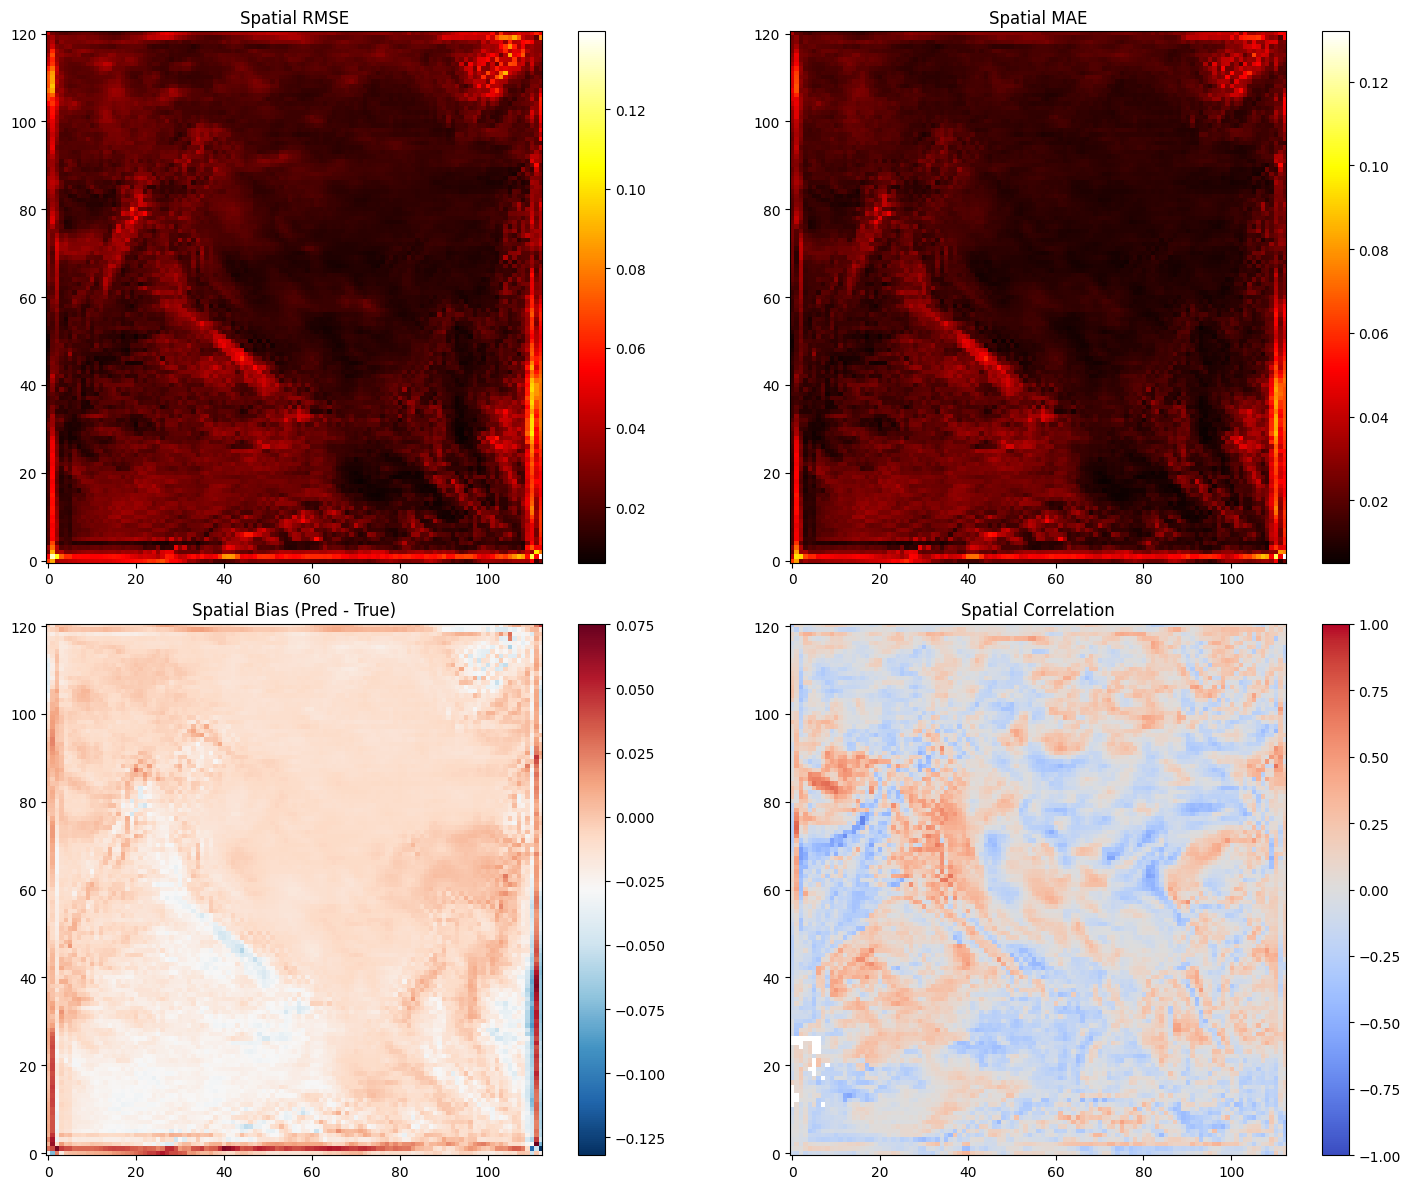

In [20]:
# Calculate metrics for each grid point
def spatial_metrics(y_true, y_pred):
    """Calculate metrics for each spatial location"""
    rmse_spatial = np.sqrt(np.mean((y_true - y_pred) ** 2, axis=0))
    mae_spatial = np.mean(np.abs(y_true - y_pred), axis=0)
    bias_spatial = np.mean(y_pred - y_true, axis=0)
    corr_spatial = np.array([np.corrcoef(y_true[:, i, j], y_pred[:, i, j])[0, 1] 
                           for i in range(y_true.shape[1]) for j in range(y_true.shape[2])])
    corr_spatial = corr_spatial.reshape(y_true.shape[1], y_true.shape[2])
    
    return rmse_spatial, mae_spatial, bias_spatial, corr_spatial

rmse_map, mae_map, bias_map, corr_map = spatial_metrics(y_val, y_pred_2d)

# Plot spatial distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RMSE map
im1 = axes[0,0].imshow(rmse_map, cmap='hot', origin='lower')
axes[0,0].set_title('Spatial RMSE')
plt.colorbar(im1, ax=axes[0,0])

# MAE map
im2 = axes[0,1].imshow(mae_map, cmap='hot', origin='lower')
axes[0,1].set_title('Spatial MAE')
plt.colorbar(im2, ax=axes[0,1])

# Bias map
im3 = axes[1,0].imshow(bias_map, cmap='RdBu_r', origin='lower')
axes[1,0].set_title('Spatial Bias (Pred - True)')
plt.colorbar(im3, ax=axes[1,0])

# Correlation map
im4 = axes[1,1].imshow(corr_map, cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
axes[1,1].set_title('Spatial Correlation')
plt.colorbar(im4, ax=axes[1,1])

plt.tight_layout()
plt.show()

#### 4. Temporal Analysis

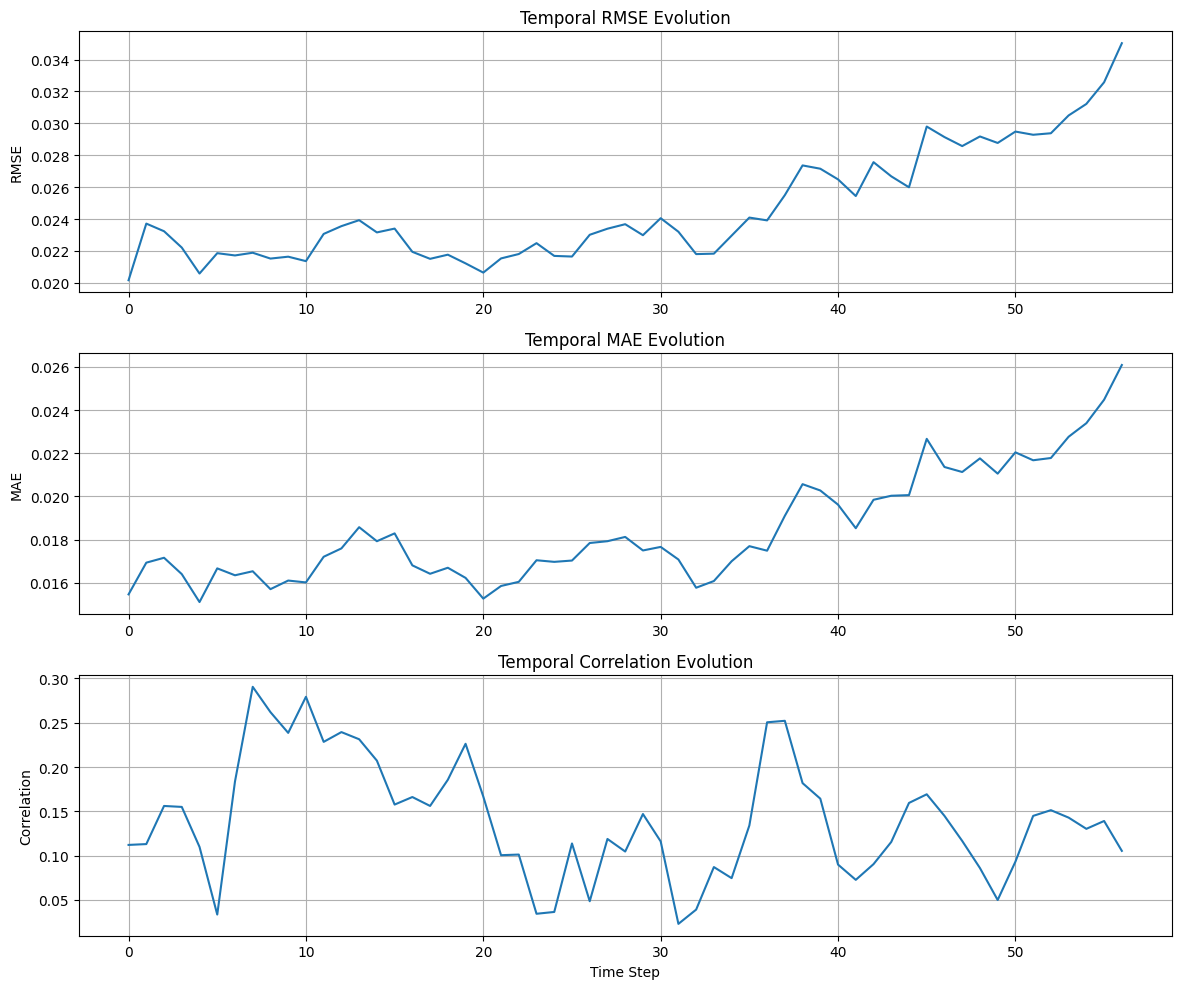

In [21]:
# Analyze performance over time
def temporal_analysis(y_true, y_pred):
    """Analyze model performance across time steps"""
    temporal_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2, axis=(1, 2)))
    temporal_mae = np.mean(np.abs(y_true - y_pred), axis=(1, 2))
    temporal_corr = np.array([np.corrcoef(y_true[i].flatten(), y_pred[i].flatten())[0, 1] 
                            for i in range(len(y_true))])
    
    return temporal_rmse, temporal_mae, temporal_corr

temporal_rmse, temporal_mae, temporal_corr = temporal_analysis(y_val, y_pred_2d)

# Plot temporal evolution
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(temporal_rmse)
axes[0].set_title('Temporal RMSE Evolution')
axes[0].set_ylabel('RMSE')
axes[0].grid(True)

axes[1].plot(temporal_mae)
axes[1].set_title('Temporal MAE Evolution')
axes[1].set_ylabel('MAE')
axes[1].grid(True)

axes[2].plot(temporal_corr)
axes[2].set_title('Temporal Correlation Evolution')
axes[2].set_ylabel('Correlation')
axes[2].set_xlabel('Time Step')
axes[2].grid(True)

plt.tight_layout()
plt.show()

#### 5. Scatter Plots and Distribution Analysis

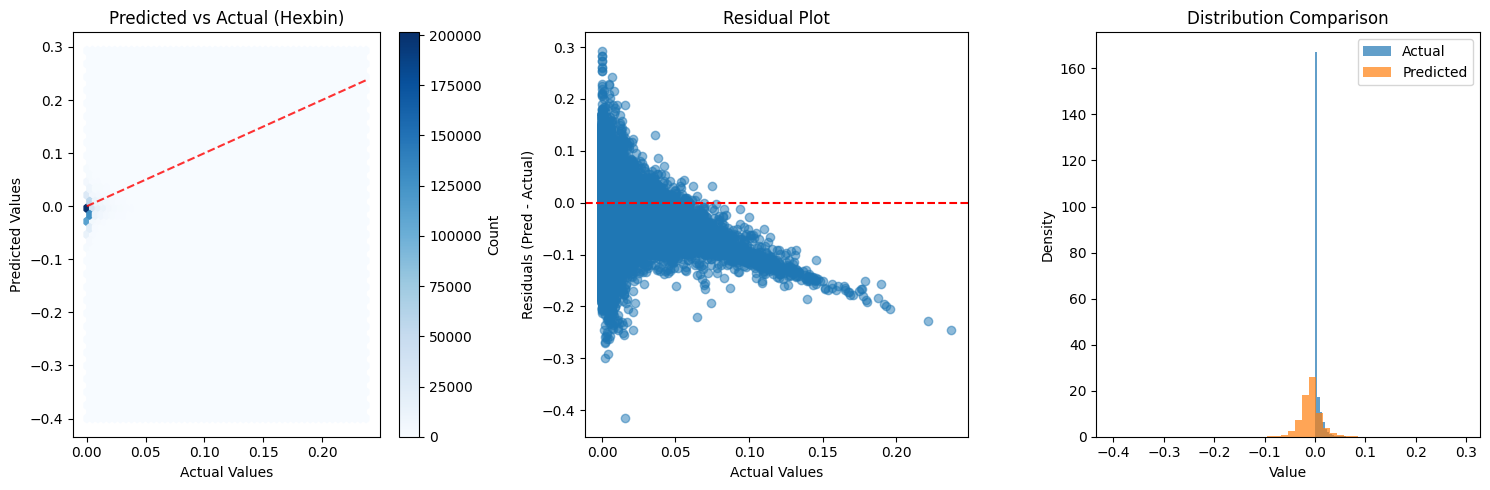

In [22]:
# Scatter plot with density
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hexbin(y_val_clean, y_pred_clean, gridsize=50, cmap='Blues')
plt.plot([y_val_clean.min(), y_val_clean.max()], [y_val_clean.min(), y_val_clean.max()], 'r--', alpha=0.8)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual (Hexbin)')
plt.colorbar(label='Count')

# Residual plot
plt.subplot(1, 3, 2)
residuals = y_pred_clean - y_val_clean
plt.scatter(y_val_clean, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Pred - Actual)')
plt.title('Residual Plot')

# Distribution comparison
plt.subplot(1, 3, 3)
plt.hist(y_val_clean, bins=50, alpha=0.7, label='Actual', density=True)
plt.hist(y_pred_clean, bins=50, alpha=0.7, label='Predicted', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

plt.tight_layout()
plt.show()

#### 6. Categorical Verification (for Precipitation)

In [23]:
# For precipitation, categorical metrics are important
def categorical_metrics(y_true, y_pred, thresholds=[0.1, 1.0, 5.0, 10.0]):
    """Calculate categorical scores for different precipitation thresholds"""
    
    results = {}
    for threshold in thresholds:
        # Binary classification for exceedance
        true_binary = (y_true >= threshold).astype(int)
        pred_binary = (y_pred >= threshold).astype(int)
        
        # Calculate metrics
        tp = np.sum((true_binary == 1) & (pred_binary == 1))
        tn = np.sum((true_binary == 0) & (pred_binary == 0))
        fp = np.sum((true_binary == 0) & (pred_binary == 1))
        fn = np.sum((true_binary == 1) & (pred_binary == 0))
        
        # Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / len(y_true)
        
        results[threshold] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        }
    
    return results

# Calculate categorical metrics
categorical_results = categorical_metrics(y_val_clean, y_pred_clean)

print("\n🌧️ CATEGORICAL PRECIPITATION VERIFICATION:")
print("=" * 60)
for threshold, scores in categorical_results.items():
    print(f"Threshold: {threshold} mm")
    print(f"  Precision: {scores['precision']:.3f}, Recall: {scores['recall']:.3f}")
    print(f"  F1-Score: {scores['f1_score']:.3f}, Accuracy: {scores['accuracy']:.3f}")
    print(f"  Contingency: TP={scores['tp']}, TN={scores['tn']}, FP={scores['fp']}, FN={scores['fn']}")
    print("-" * 40)


🌧️ CATEGORICAL PRECIPITATION VERIFICATION:
Threshold: 0.1 mm
  Precision: 0.000, Recall: 0.000
  F1-Score: 0.000, Accuracy: 0.998
  Contingency: TP=0, TN=777858, FP=1208, FN=295
----------------------------------------
Threshold: 1.0 mm
  Precision: 0.000, Recall: 0.000
  F1-Score: 0.000, Accuracy: 1.000
  Contingency: TP=0, TN=779361, FP=0, FN=0
----------------------------------------
Threshold: 5.0 mm
  Precision: 0.000, Recall: 0.000
  F1-Score: 0.000, Accuracy: 1.000
  Contingency: TP=0, TN=779361, FP=0, FN=0
----------------------------------------
Threshold: 10.0 mm
  Precision: 0.000, Recall: 0.000
  F1-Score: 0.000, Accuracy: 1.000
  Contingency: TP=0, TN=779361, FP=0, FN=0
----------------------------------------


####  7. Skill Score Comparison

In [24]:
# Compare with baseline models
def baseline_models(y_true):
    """Calculate baseline model performance"""
    # Persistence forecast (yesterday's value for today)
    persistence = np.roll(y_true, 1)
    persistence[0] = y_true[0]
    
    # Climatology (mean value)
    climatology = np.mean(y_true) * np.ones_like(y_true)
    
    # Linear trend
    x = np.arange(len(y_true))
    trend_coef = np.polyfit(x, y_true, 1)
    trend = np.polyval(trend_coef, x)
    
    return {
        'persistence': persistence,
        'climatology': climatology,
        'trend': trend
    }

# Calculate baseline predictions
baselines = baseline_models(y_val_clean)

print("\n📈 COMPARISON WITH BASELINE MODELS:")
print("=" * 50)
print(f"{'Model':<12} {'RMSE':<8} {'MAE':<8} {'R²':<8}")
print("-" * 50)

# Your model
print(f"{'Your Model':<12} {metrics['rmse']:.4f}  {metrics['mae']:.4f}  {metrics['r2']:.4f}")

# Baseline models
for name, pred in baselines.items():
    rmse_base = np.sqrt(mean_squared_error(y_val_clean, pred))
    mae_base = mean_absolute_error(y_val_clean, pred)
    r2_base = r2_score(y_val_clean, pred)
    print(f"{name.capitalize():<12} {rmse_base:.4f}  {mae_base:.4f}  {r2_base:.4f}")

# Calculate skill scores
persistence_rmse = np.sqrt(mean_squared_error(y_val_clean, baselines['persistence']))
skill_score_rmse = 1 - (metrics['rmse'] / persistence_rmse)

print(f"\nSkill Score vs Persistence: {skill_score_rmse:.4f}")
print(f"Improvement over Persistence: {skill_score_rmse*100:.2f}%")


📈 COMPARISON WITH BASELINE MODELS:
Model        RMSE     MAE      R²      
--------------------------------------------------
Your Model   0.0249  0.0184  -9.4687
Persistence  0.0021  0.0006  0.9264
Climatology  0.0077  0.0046  0.0000
Trend        0.0077  0.0045  0.0078

Skill Score vs Persistence: -10.9238
Improvement over Persistence: -1092.38%


#### 8. Extreme Events Analysis

In [25]:
# Analyze performance for extreme events
def extreme_events_analysis(y_true, y_pred, extreme_percentile=95):
    """Analyze model performance for extreme values"""
    
    # Identify extreme events
    extreme_threshold = np.percentile(y_true, extreme_percentile)
    extreme_mask = y_true >= extreme_threshold
    
    # Calculate metrics for extremes
    extreme_true = y_true[extreme_mask]
    extreme_pred = y_pred[extreme_mask]
    
    if len(extreme_true) > 0:
        extreme_rmse = np.sqrt(mean_squared_error(extreme_true, extreme_pred))
        extreme_mae = mean_absolute_error(extreme_true, extreme_pred)
        extreme_bias = np.mean(extreme_pred - extreme_true)
        extreme_corr = np.corrcoef(extreme_true, extreme_pred)[0, 1]
        
        return {
            'threshold': extreme_threshold,
            'count': len(extreme_true),
            'rmse': extreme_rmse,
            'mae': extreme_mae,
            'bias': extreme_bias,
            'correlation': extreme_corr
        }
    else:
        return None

extreme_results = extreme_events_analysis(y_val_clean, y_pred_clean)

if extreme_results:
    print("\n⚡ EXTREME EVENTS ANALYSIS:")
    print("=" * 40)
    for key, value in extreme_results.items():
        print(f"{key.capitalize():<12}: {value:.4f}")


⚡ EXTREME EVENTS ANALYSIS:
Threshold   : 0.0176
Count       : 38969.0000
Rmse        : 0.0379
Mae         : 0.0316
Bias        : -0.0288
Correlation : -0.0357


#### 9. Summary Report

In [26]:
# Generate final summary report
def generate_summary_report(metrics, categorical_results, extreme_results):
    """Generate comprehensive model evaluation report"""
    
    print("\n" + "="*60)
    print("🎯 FINAL MODEL EVALUATION SUMMARY")
    print("="*60)
    
    print("\n📊 OVERALL PERFORMANCE:")
    print(f"  RMSE: {metrics['rmse']:.4f}")
    print(f"  MAE: {metrics['mae']:.4f}")
    print(f"  R²: {metrics['r2']:.4f}")
    print(f"  Bias: {metrics['bias']:.4f}")
    print(f"  Correlation: {metrics['pearson_corr']:.4f}")
    
    print("\n🌧️ PRECIPITATION DETECTION SKILL:")
    for threshold, scores in categorical_results.items():
        print(f"  >{threshold}mm - F1: {scores['f1_score']:.3f}, Precision: {scores['precision']:.3f}")
    
    if extreme_results:
        print(f"\n⚡ EXTREME EVENTS (>{extreme_results['threshold']:.2f}mm):")
        print(f"  RMSE: {extreme_results['rmse']:.4f}, Bias: {extreme_results['bias']:.4f}")
    
    print(f"\n📈 MODEL SKILL:")
    print(f"  Skill Score: {metrics['skill_score']:.4f}")
    print(f"  Improvement over baseline: {metrics['skill_score']*100:.2f}%")
    
    # Overall assessment
    overall_score = (metrics['r2'] + (1 - metrics['mape']/100) + metrics['skill_score']) / 3
    print(f"\n🏆 OVERALL SCORE: {overall_score:.3f}/1.0")
    
    if overall_score > 0.8:
        assessment = "EXCELLENT"
    elif overall_score > 0.6:
        assessment = "GOOD"
    elif overall_score > 0.4:
        assessment = "FAIR"
    else:
        assessment = "NEEDS IMPROVEMENT"
    
    print(f"  ASSESSMENT: {assessment}")

# Generate the final report
generate_summary_report(metrics, categorical_results, extreme_results)


🎯 FINAL MODEL EVALUATION SUMMARY

📊 OVERALL PERFORMANCE:
  RMSE: 0.0249
  MAE: 0.0184
  R²: -9.4687
  Bias: -0.0119
  Correlation: 0.1507

🌧️ PRECIPITATION DETECTION SKILL:
  >0.1mm - F1: 0.000, Precision: 0.000
  >1.0mm - F1: 0.000, Precision: 0.000
  >5.0mm - F1: 0.000, Precision: 0.000
  >10.0mm - F1: 0.000, Precision: 0.000

⚡ EXTREME EVENTS (>0.02mm):
  RMSE: 0.0379, Bias: -0.0288

📈 MODEL SKILL:
  Skill Score: -141.1776
  Improvement over baseline: -14117.76%

🏆 OVERALL SCORE: -244185.445/1.0
  ASSESSMENT: NEEDS IMPROVEMENT


#### 1. Side-by-Side Comparison Plots

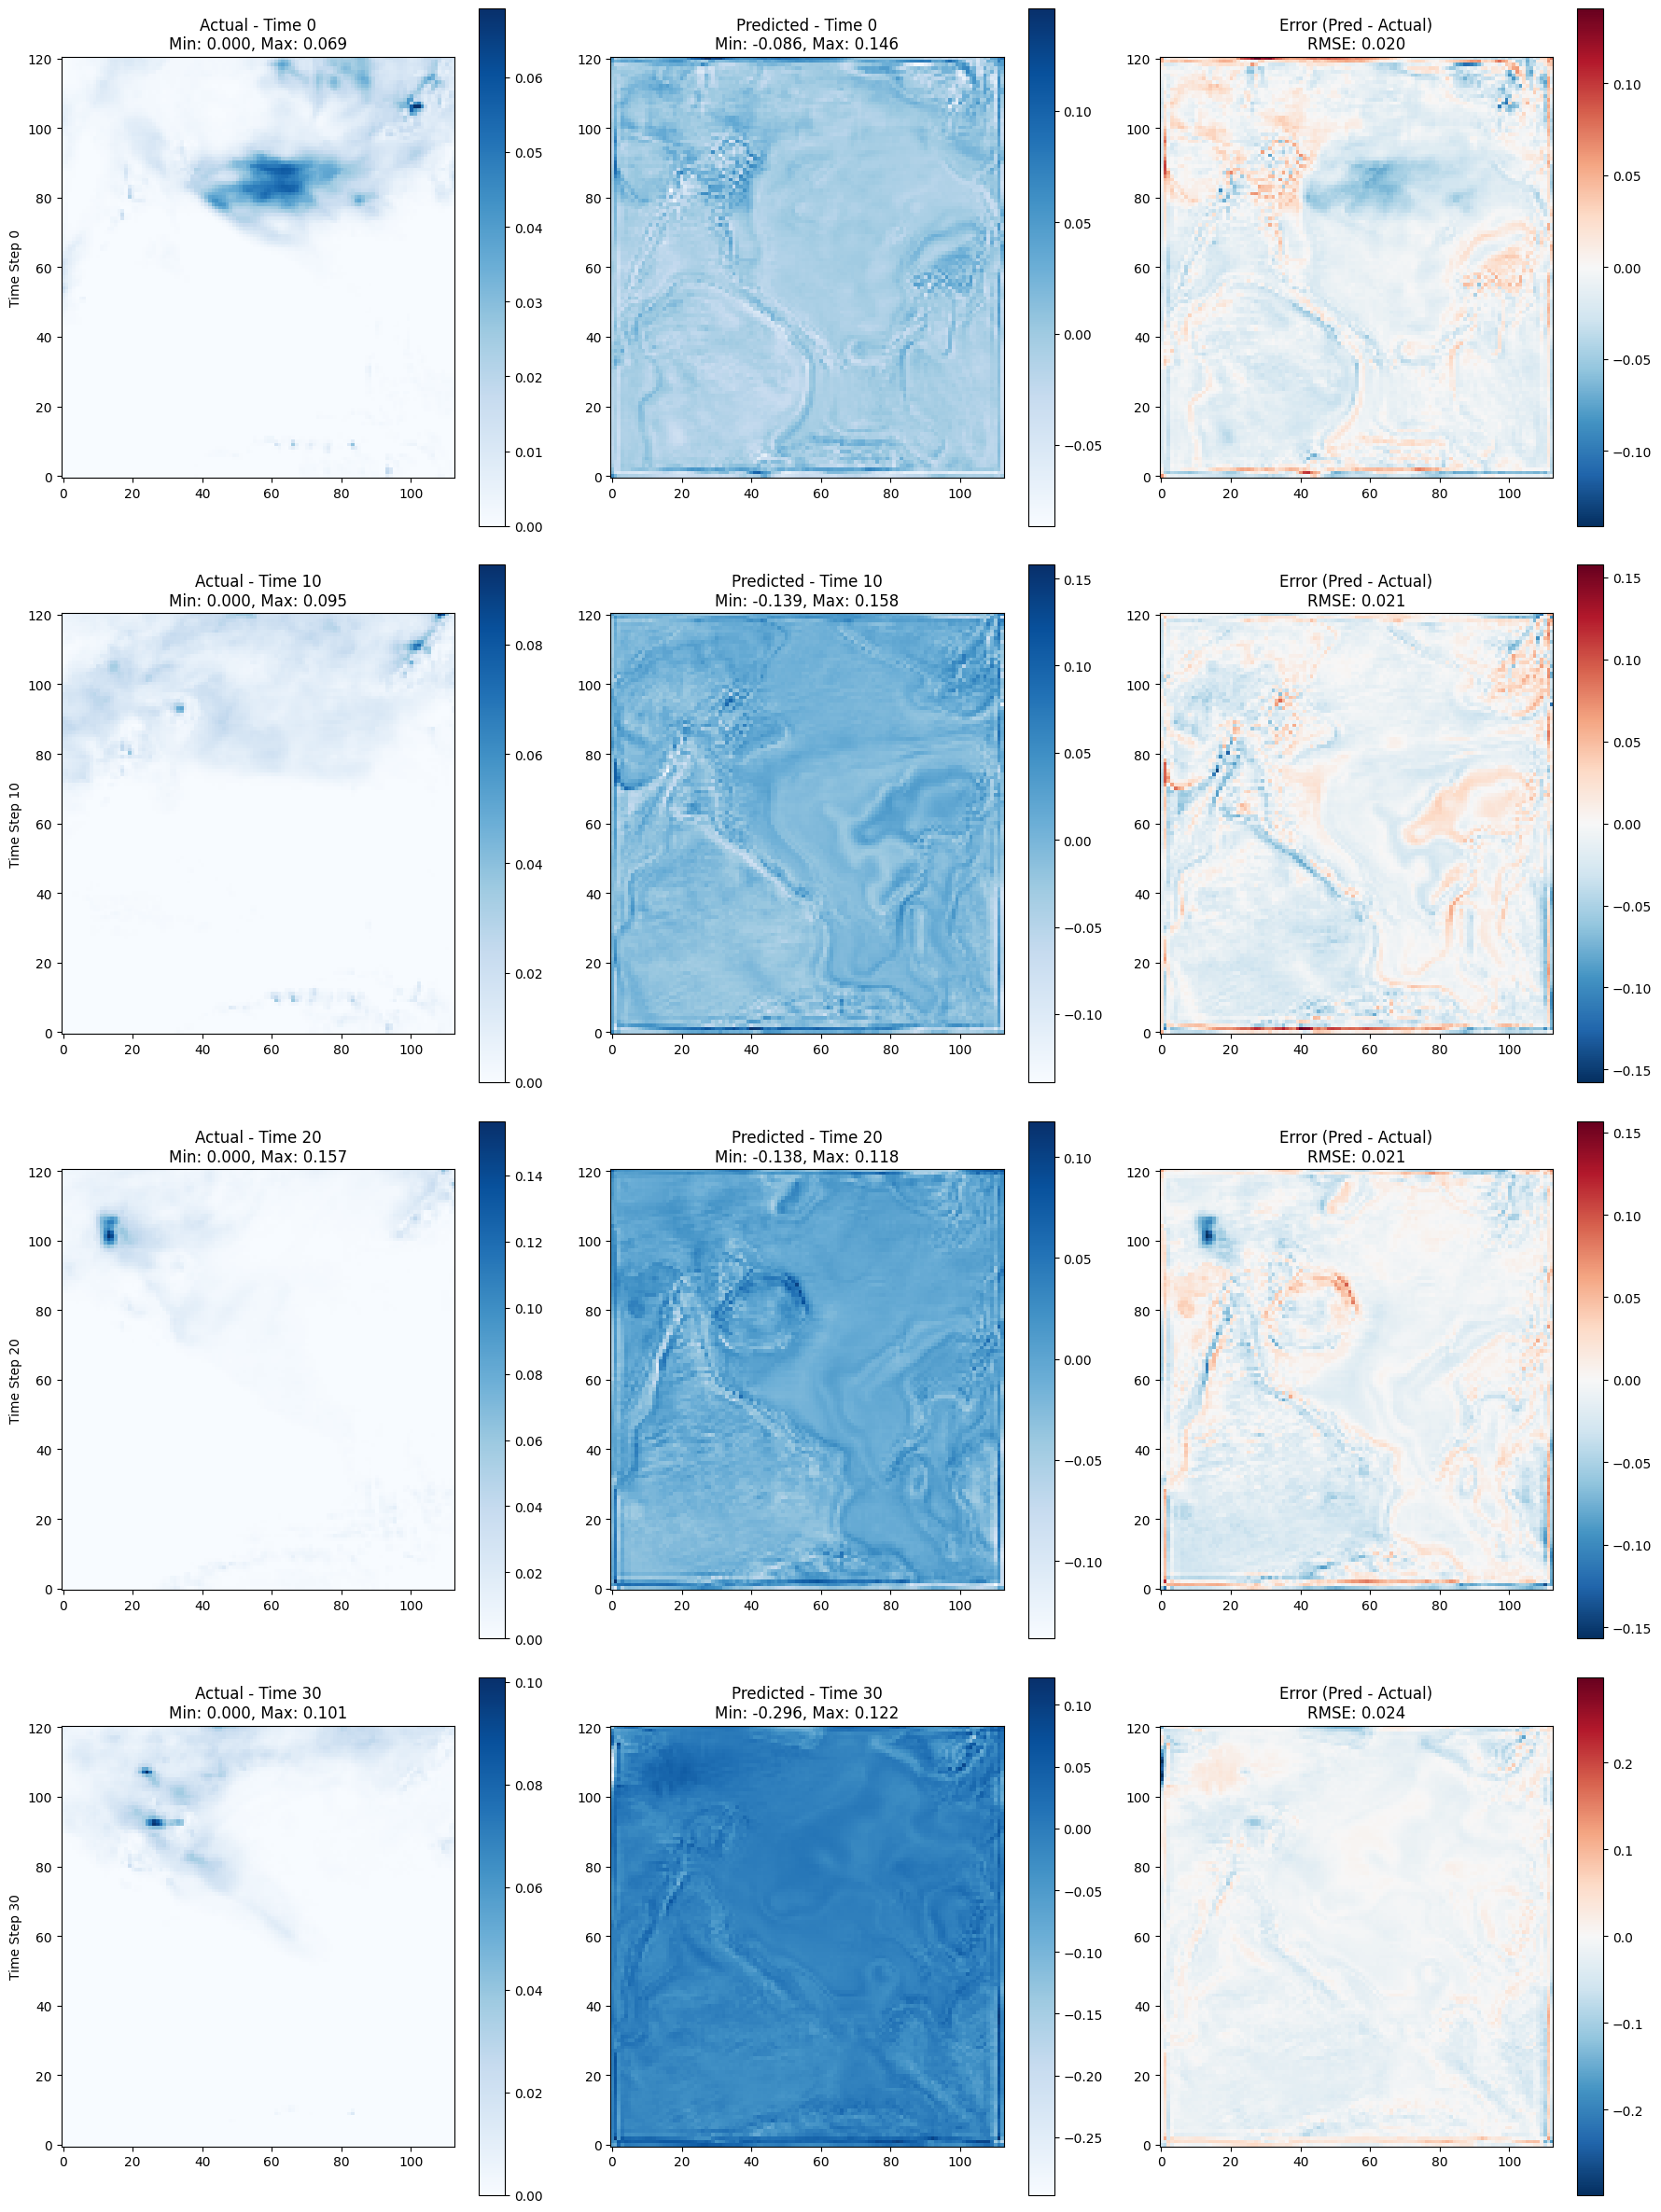

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Select a few time steps for visualization
time_indices = [0, 10, 20, 30]  # Different time steps

fig, axes = plt.subplots(len(time_indices), 3, figsize=(18, 6*len(time_indices)))

# If only one time index, ensure axes is 2D
if len(time_indices) == 1:
    axes = axes.reshape(1, -1)

for i, idx in enumerate(time_indices):
    # Actual values
    im1 = axes[i, 0].imshow(y_val[idx], cmap='Blues', origin='lower')
    axes[i, 0].set_title(f'Actual - Time {idx}\nMin: {y_val[idx].min():.3f}, Max: {y_val[idx].max():.3f}')
    axes[i, 0].set_ylabel(f'Time Step {idx}')
    plt.colorbar(im1, ax=axes[i, 0])
    
    # Predicted values
    im2 = axes[i, 1].imshow(y_pred_2d[idx], cmap='Blues', origin='lower')
    axes[i, 1].set_title(f'Predicted - Time {idx}\nMin: {y_pred_2d[idx].min():.3f}, Max: {y_pred_2d[idx].max():.3f}')
    plt.colorbar(im2, ax=axes[i, 1])
    
    # Difference (Error)
    diff = y_pred_2d[idx] - y_val[idx]
    im3 = axes[i, 2].imshow(diff, cmap='RdBu_r', origin='lower', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
    axes[i, 2].set_title(f'Error (Pred - Actual)\nRMSE: {np.sqrt(np.mean(diff**2)):.3f}')
    plt.colorbar(im3, ax=axes[i, 2])

plt.tight_layout()
plt.show()

#### 2. Mean Spatial Patterns

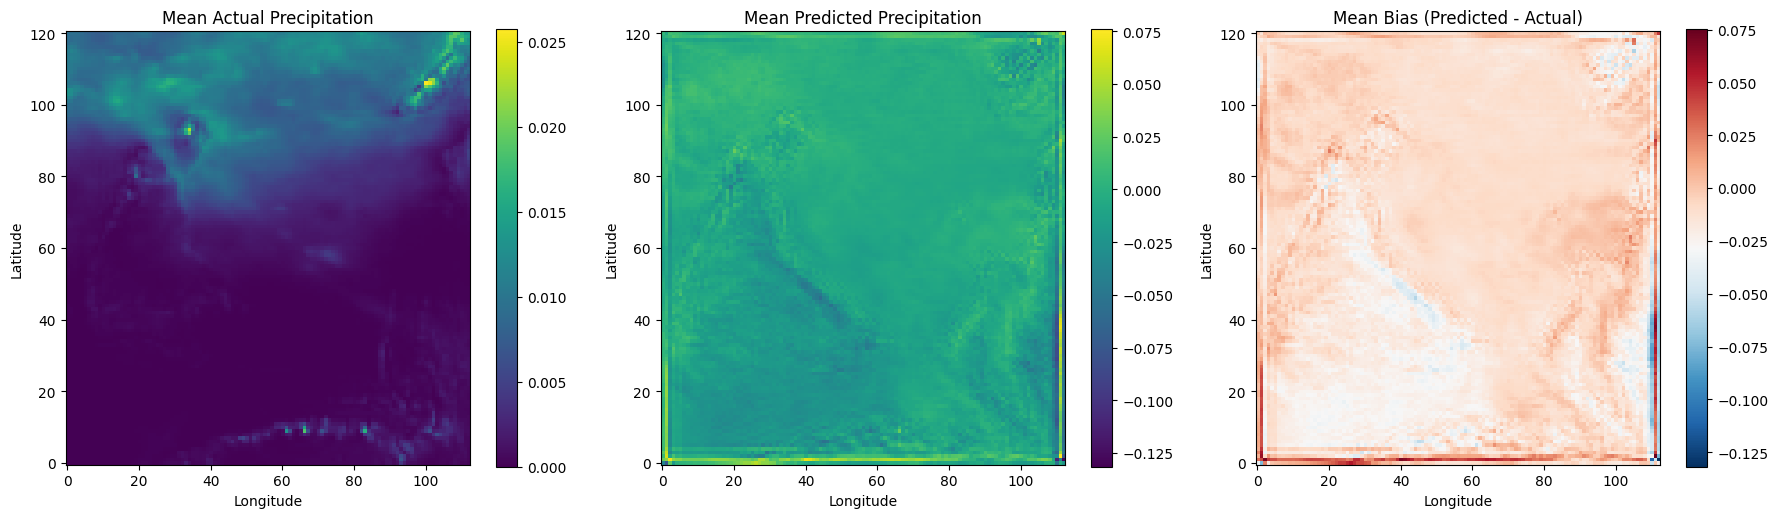

Global Mean Actual: 0.0034
Global Mean Predicted: -0.0085
Global Mean Bias: -0.0119


In [28]:
# Calculate mean patterns
mean_actual = np.mean(y_val, axis=0)
mean_predicted = np.mean(y_pred_2d, axis=0)
mean_bias = mean_predicted - mean_actual

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean Actual
im1 = axes[0].imshow(mean_actual, cmap='viridis', origin='lower')
axes[0].set_title('Mean Actual Precipitation')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0])

# Mean Predicted
im2 = axes[1].imshow(mean_predicted, cmap='viridis', origin='lower')
axes[1].set_title('Mean Predicted Precipitation')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[1])

# Mean Bias
im3 = axes[2].imshow(mean_bias, cmap='RdBu_r', origin='lower')
axes[2].set_title('Mean Bias (Predicted - Actual)')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"Global Mean Actual: {mean_actual.mean():.4f}")
print(f"Global Mean Predicted: {mean_predicted.mean():.4f}")
print(f"Global Mean Bias: {mean_bias.mean():.4f}")

#### 3. Spatial Error Metrics

C:\Users\mizan\anaconda3\envs\mlgpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\mizan\anaconda3\envs\mlgpu\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


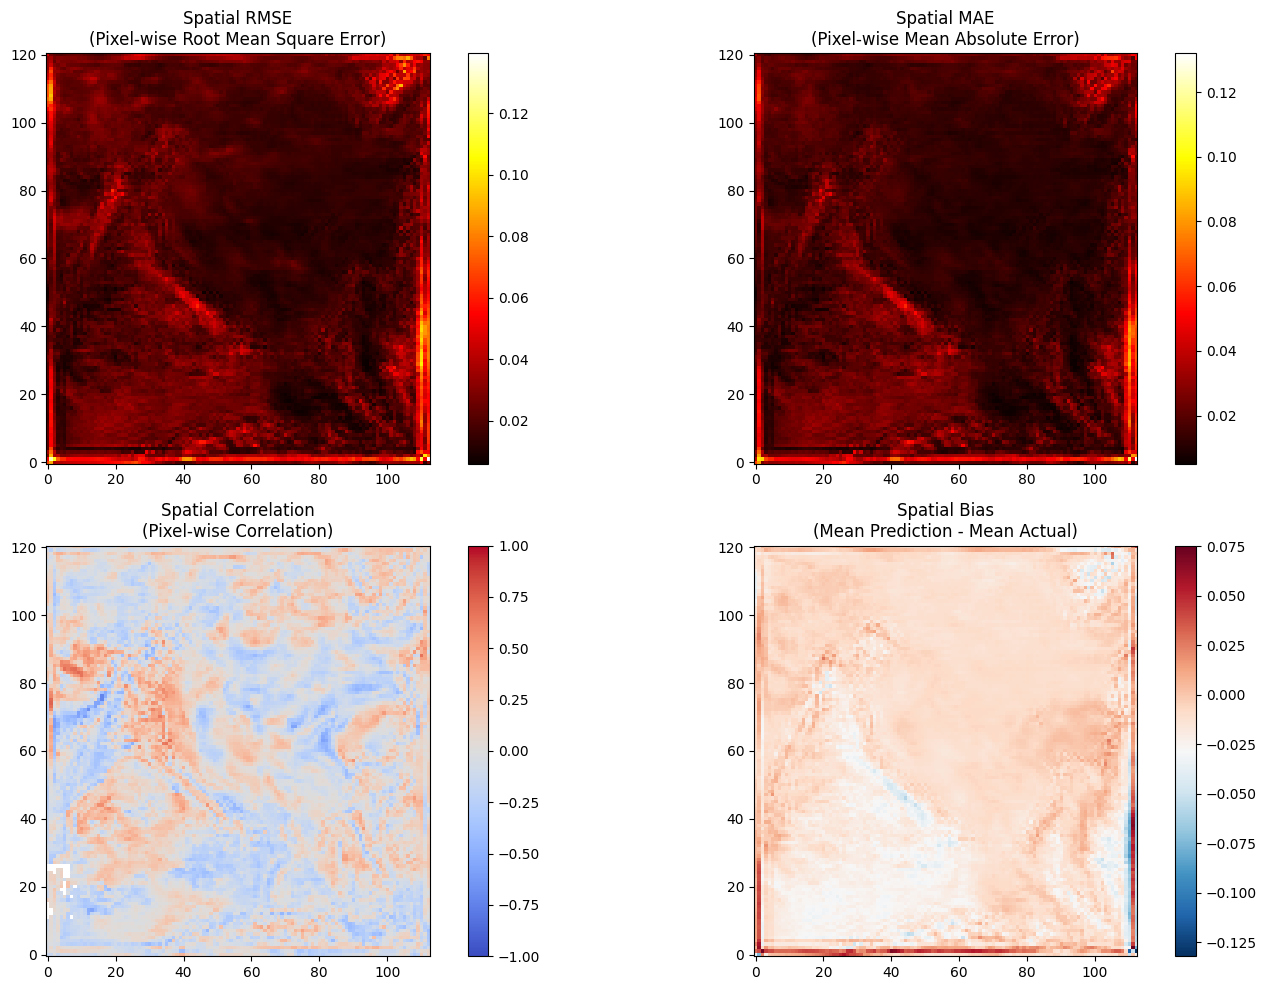

Mean Spatial RMSE: 0.0224
Mean Spatial MAE: 0.0184
Mean Spatial Correlation: nan


In [29]:
# Calculate spatial error metrics
spatial_rmse = np.sqrt(np.mean((y_val - y_pred_2d) ** 2, axis=0))
spatial_mae = np.mean(np.abs(y_val - y_pred_2d), axis=0)
spatial_correlation = np.array([np.corrcoef(y_val[:, i, j], y_pred_2d[:, i, j])[0, 1] 
                              for i in range(y_val.shape[1]) for j in range(y_val.shape[2])])
spatial_correlation = spatial_correlation.reshape(y_val.shape[1], y_val.shape[2])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Spatial RMSE
im1 = axes[0,0].imshow(spatial_rmse, cmap='hot', origin='lower')
axes[0,0].set_title('Spatial RMSE\n(Pixel-wise Root Mean Square Error)')
plt.colorbar(im1, ax=axes[0,0])

# Spatial MAE
im2 = axes[0,1].imshow(spatial_mae, cmap='hot', origin='lower')
axes[0,1].set_title('Spatial MAE\n(Pixel-wise Mean Absolute Error)')
plt.colorbar(im2, ax=axes[0,1])

# Spatial Correlation
im3 = axes[1,0].imshow(spatial_correlation, cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
axes[1,0].set_title('Spatial Correlation\n(Pixel-wise Correlation)')
plt.colorbar(im3, ax=axes[1,0])

# Spatial Bias (from previous calculation)
im4 = axes[1,1].imshow(mean_bias, cmap='RdBu_r', origin='lower')
axes[1,1].set_title('Spatial Bias\n(Mean Prediction - Mean Actual)')
plt.colorbar(im4, ax=axes[1,1])

plt.tight_layout()
plt.show()

print(f"Mean Spatial RMSE: {spatial_rmse.mean():.4f}")
print(f"Mean Spatial MAE: {spatial_mae.mean():.4f}")
print(f"Mean Spatial Correlation: {spatial_correlation.mean():.4f}")

#### 4. Statistical Distribution Maps

C:\Users\mizan\AppData\Local\Temp\ipykernel_18608\3331453663.py:20: RuntimeWarning: divide by zero encountered in divide
  std_ratio = std_predicted / std_actual
C:\Users\mizan\AppData\Local\Temp\ipykernel_18608\3331453663.py:36: RuntimeWarning: divide by zero encountered in divide
  max_ratio = max_predicted / max_actual


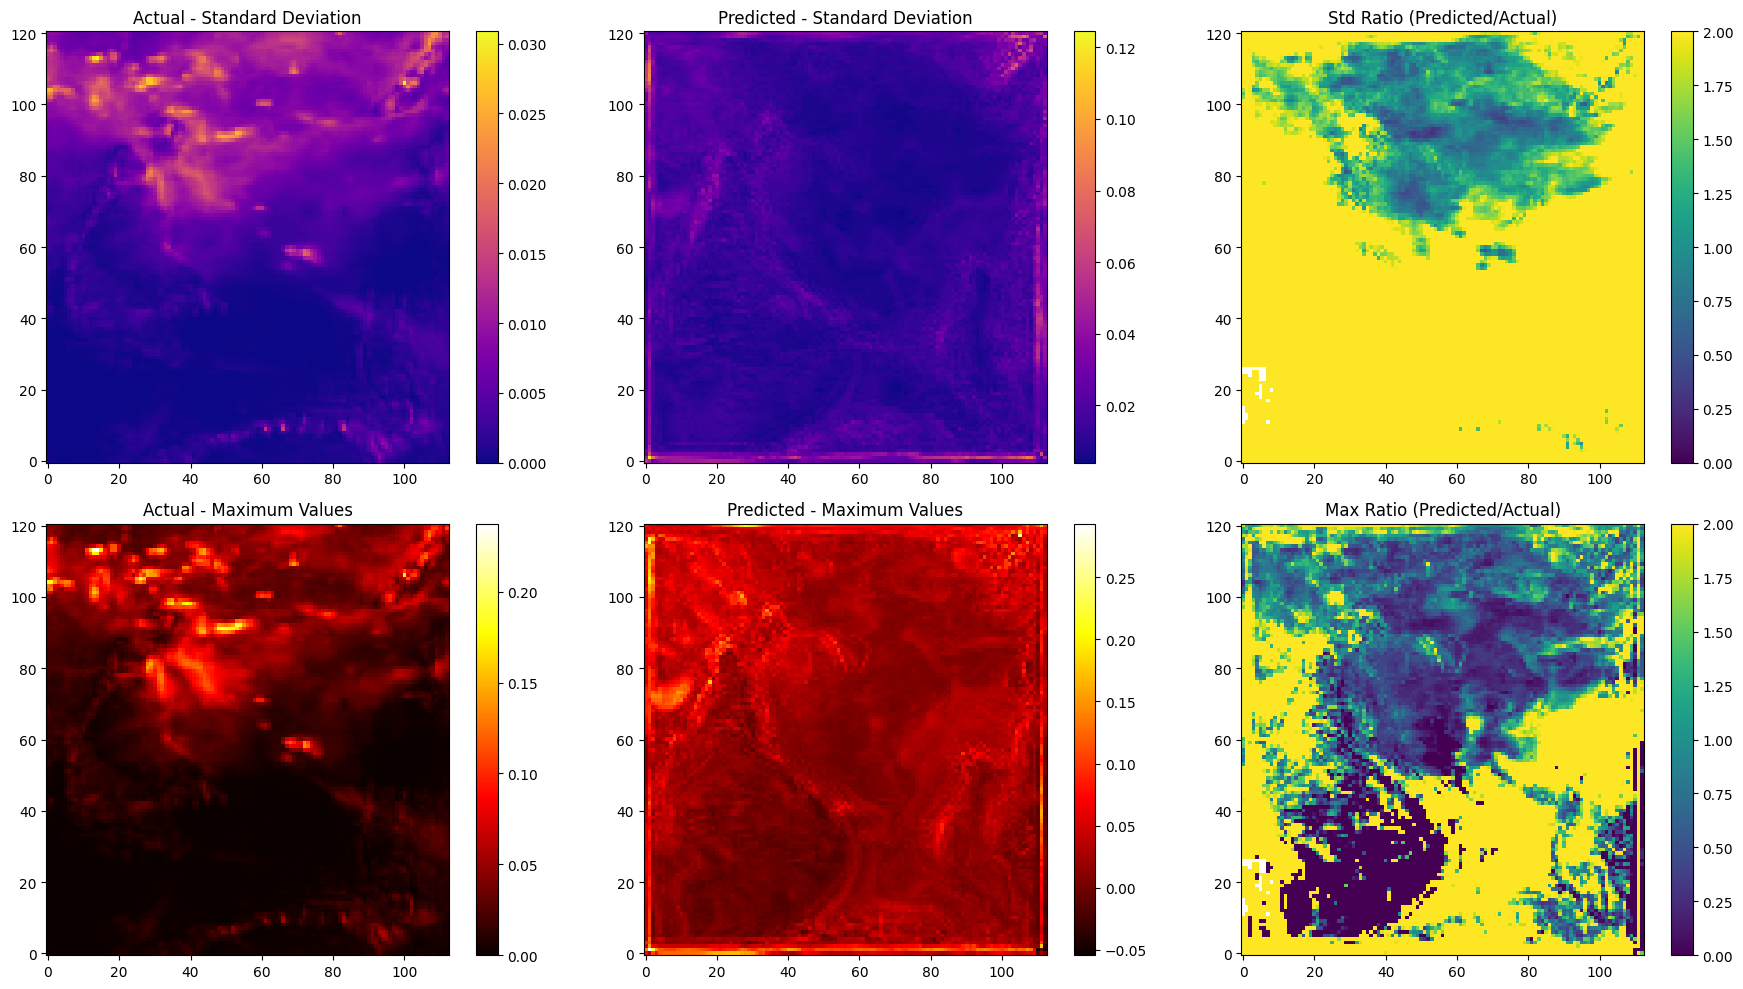

In [30]:
# Calculate spatial statistics
std_actual = np.std(y_val, axis=0)
std_predicted = np.std(y_pred_2d, axis=0)
max_actual = np.max(y_val, axis=0)
max_predicted = np.max(y_pred_2d, axis=0)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Standard Deviation - Actual
im1 = axes[0,0].imshow(std_actual, cmap='plasma', origin='lower')
axes[0,0].set_title('Actual - Standard Deviation')
plt.colorbar(im1, ax=axes[0,0])

# Standard Deviation - Predicted
im2 = axes[0,1].imshow(std_predicted, cmap='plasma', origin='lower')
axes[0,1].set_title('Predicted - Standard Deviation')
plt.colorbar(im2, ax=axes[0,1])

# Std Ratio
std_ratio = std_predicted / std_actual
im3 = axes[0,2].imshow(std_ratio, cmap='viridis', origin='lower', vmin=0, vmax=2)
axes[0,2].set_title('Std Ratio (Predicted/Actual)')
plt.colorbar(im3, ax=axes[0,2])

# Maximum - Actual
im4 = axes[1,0].imshow(max_actual, cmap='hot', origin='lower')
axes[1,0].set_title('Actual - Maximum Values')
plt.colorbar(im4, ax=axes[1,0])

# Maximum - Predicted
im5 = axes[1,1].imshow(max_predicted, cmap='hot', origin='lower')
axes[1,1].set_title('Predicted - Maximum Values')
plt.colorbar(im5, ax=axes[1,1])

# Max Ratio
max_ratio = max_predicted / max_actual
im6 = axes[1,2].imshow(max_ratio, cmap='viridis', origin='lower', vmin=0, vmax=2)
axes[1,2].set_title('Max Ratio (Predicted/Actual)')
plt.colorbar(im6, ax=axes[1,2])

plt.tight_layout()
plt.show()

#### 5. Regional Analysis

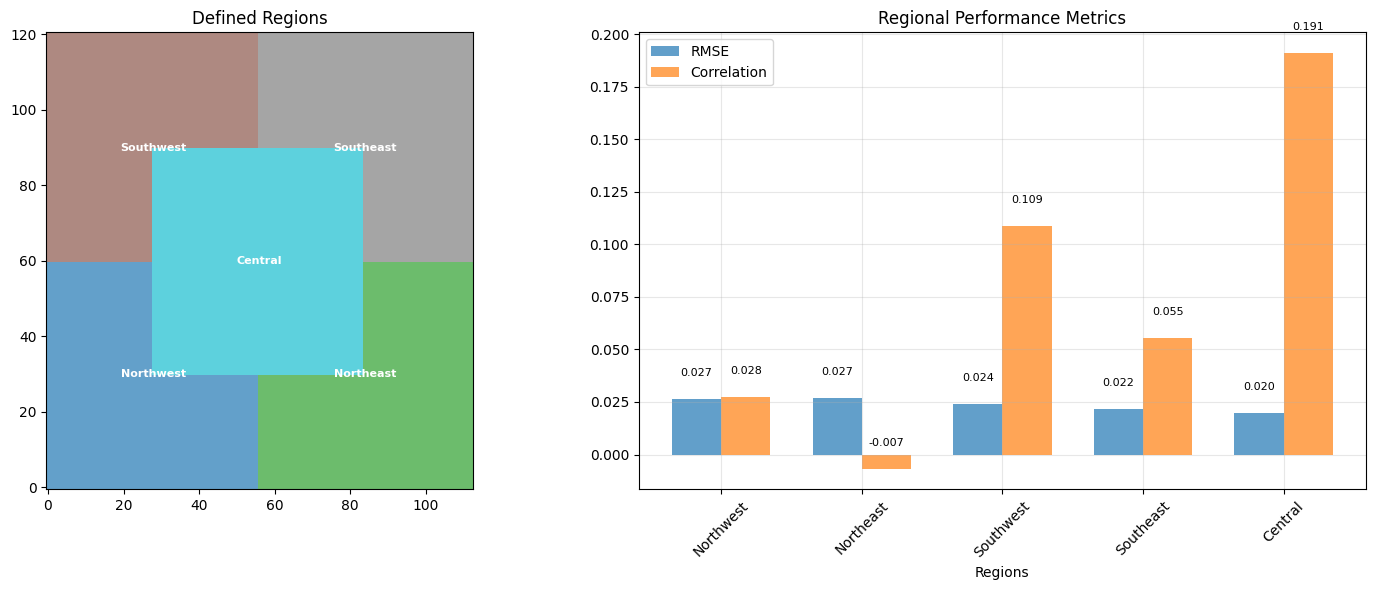

Regional Performance Summary:
Northwest    - RMSE: 0.0265, Correlation: 0.0276
Northeast    - RMSE: 0.0268, Correlation: -0.0067
Southwest    - RMSE: 0.0242, Correlation: 0.1089
Southeast    - RMSE: 0.0217, Correlation: 0.0552
Central      - RMSE: 0.0197, Correlation: 0.1909


In [31]:
# Define regions (you can adjust these based on your domain)
def define_regions(shape):
    """Define different regions for analysis"""
    lat_size, lon_size = shape
    regions = {
        'Northwest': (slice(0, lat_size//2), slice(0, lon_size//2)),
        'Northeast': (slice(0, lat_size//2), slice(lon_size//2, lon_size)),
        'Southwest': (slice(lat_size//2, lat_size), slice(0, lon_size//2)),
        'Southeast': (slice(lat_size//2, lat_size), slice(lon_size//2, lon_size)),
        'Central': (slice(lat_size//4, 3*lat_size//4), slice(lon_size//4, 3*lon_size//4))
    }
    return regions

regions = define_regions(y_val[0].shape)

# Plot regions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Regional mask
regional_mask = np.zeros(y_val[0].shape)
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, (name, region_slice) in enumerate(regions.items()):
    regional_mask[region_slice] = i + 1

im1 = axes[0].imshow(regional_mask, cmap='tab10', origin='lower', alpha=0.7)
axes[0].set_title('Defined Regions')
for i, (name, region_slice) in enumerate(regions.items()):
    lat_center = (region_slice[0].start + region_slice[0].stop) // 2
    lon_center = (region_slice[1].start + region_slice[1].stop) // 2
    axes[0].text(lon_center, lat_center, name, ha='center', va='center', 
                fontweight='bold', color='white', fontsize=8)

# Regional performance
regional_stats = {}
for name, region_slice in regions.items():
    actual_region = y_val[:, region_slice[0], region_slice[1]]
    pred_region = y_pred_2d[:, region_slice[0], region_slice[1]]
    
    rmse_regional = np.sqrt(np.mean((actual_region - pred_region) ** 2))
    corr_regional = np.corrcoef(actual_region.flatten(), pred_region.flatten())[0, 1]
    
    regional_stats[name] = {'rmse': rmse_regional, 'correlation': corr_regional}

# Bar plot of regional performance
names = list(regional_stats.keys())
rmses = [regional_stats[name]['rmse'] for name in names]
correlations = [regional_stats[name]['correlation'] for name in names]

x = np.arange(len(names))
width = 0.35

bars1 = axes[1].bar(x - width/2, rmses, width, label='RMSE', alpha=0.7)
bars2 = axes[1].bar(x + width/2, correlations, width, label='Correlation', alpha=0.7)

axes[1].set_xlabel('Regions')
axes[1].set_title('Regional Performance Metrics')
axes[1].set_xticks(x)
axes[1].set_xticklabels(names, rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars1, rmses):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

for bar, value in zip(bars2, correlations):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("Regional Performance Summary:")
for name, stats in regional_stats.items():
    print(f"{name:12} - RMSE: {stats['rmse']:.4f}, Correlation: {stats['correlation']:.4f}")

#### 6. Quantile-Quantile Plot by Location

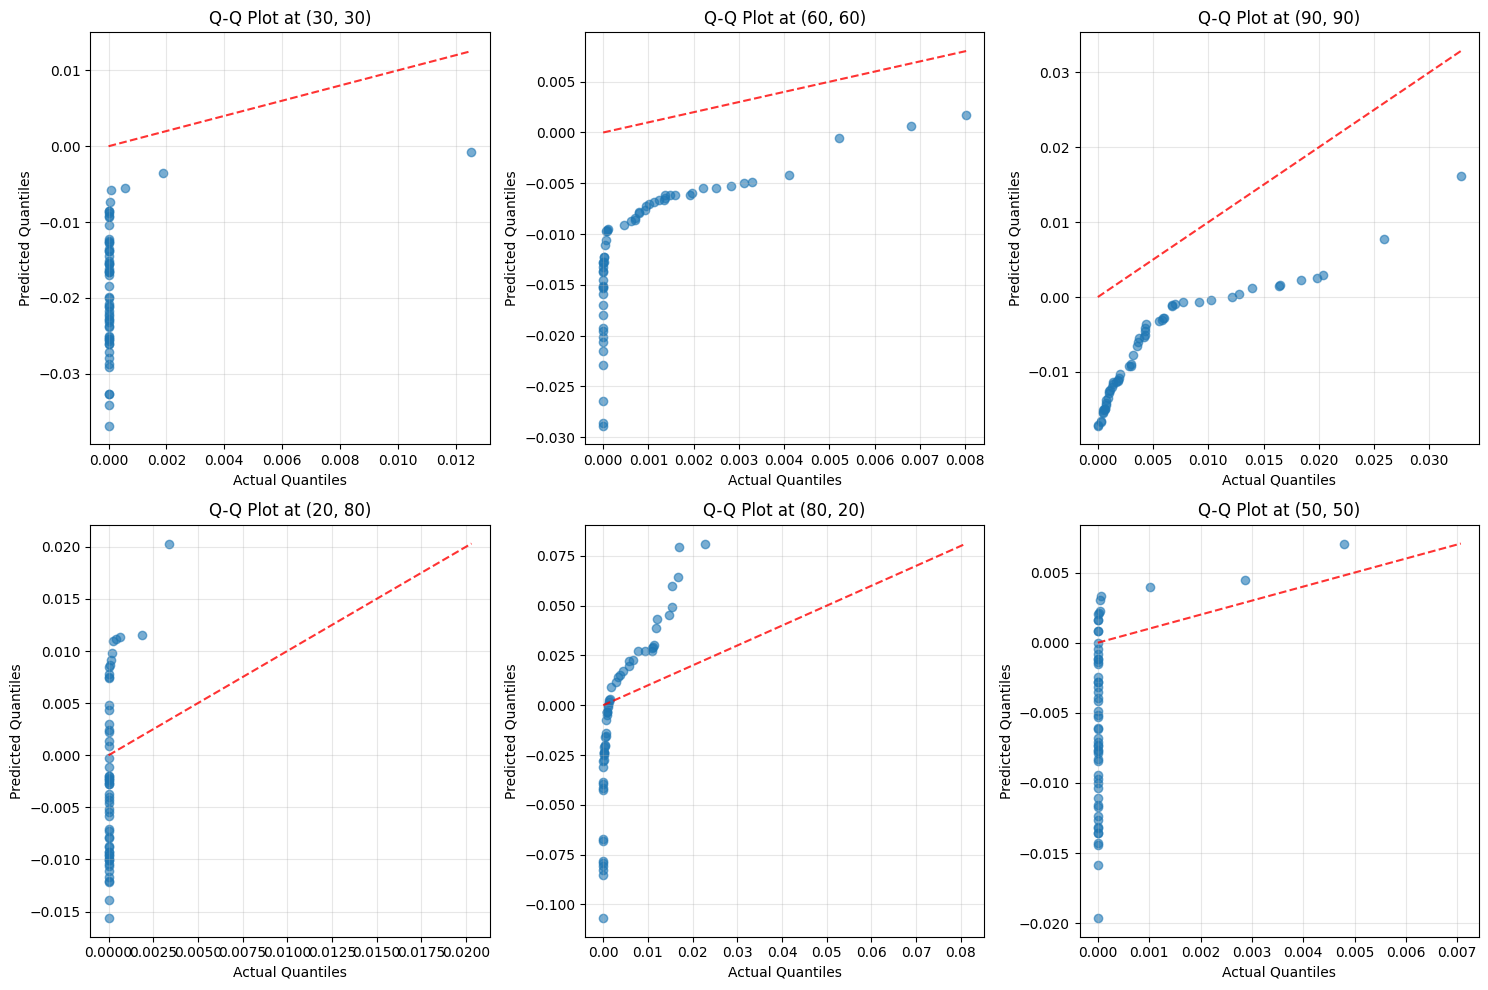

In [32]:
# Q-Q plots for different locations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
locations = [
    (30, 30), (60, 60), (90, 90),  # Three points
    (20, 80), (80, 20), (50, 50)   # Three more points
]

for idx, (lat, lon) in enumerate(locations):
    row = idx // 3
    col = idx % 3
    
    actual_ts = y_val[:, lat, lon]
    pred_ts = y_pred_2d[:, lat, lon]
    
    # Sort values for Q-Q plot
    actual_sorted = np.sort(actual_ts)
    pred_sorted = np.sort(pred_ts)
    
    axes[row, col].scatter(actual_sorted, pred_sorted, alpha=0.6)
    max_val = max(actual_sorted.max(), pred_sorted.max())
    axes[row, col].plot([0, max_val], [0, max_val], 'r--', alpha=0.8)
    axes[row, col].set_xlabel('Actual Quantiles')
    axes[row, col].set_ylabel('Predicted Quantiles')
    axes[row, col].set_title(f'Q-Q Plot at ({lat}, {lon})')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()